# Импорт библиотек для работы


In [122]:
import os
import requests
import glob

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # для qq plot

from scipy.stats import shapiro 
from scipy.stats import normaltest 
from scipy.stats import binom_test
from scipy.stats import mannwhitneyu 
from scipy.stats import ttest_ind 
from statsmodels.stats.weightstats import ztest 
from scipy.stats import kruskal 
from scipy import stats 
from scipy.stats import f_oneway
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Загружаем датасет о тенисных матчах

In [29]:
def download_csv_files_for_years(repo_url, folder_path, save_dir, start_year, end_year):
    if not os.path.exists(save_dir): # check if  save directory exists, if not create it
        os.makedirs(save_dir)

    with requests.Session() as session: # create session
        for year in range(start_year, end_year + 1): # loop through years
            file_url = f'{repo_url}/{folder_path}atp_matches_{year}.csv' # construct filr url (repo_url + folder_path + file_name)
            response = session.get(file_url) #send request
            if response.ok: # check if request was successful
                file_name = os.path.join(save_dir, f'atp_matches_{year}.csv') # construct file name
                with open(file_name, 'wb') as file: # open file
                    file.write(response.content) # write content
                    print(f'Downloaded {file_name}') # print success message
            else: # if request was not successful
                print(f'Failed to download atp_matches_{year}.csv') # print failure message

repo_url = 'https://raw.github.com/JeffSackmann/tennis_atp'
folder_path = 'master/'
save_dir = 'github_data'
start_year = 1968
end_year = 2023
download_csv_files_for_years(repo_url, folder_path, save_dir, start_year, end_year)
#https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_1968.csv

Downloaded github_data\atp_matches_1968.csv
Downloaded github_data\atp_matches_1969.csv
Downloaded github_data\atp_matches_1970.csv
Downloaded github_data\atp_matches_1971.csv
Downloaded github_data\atp_matches_1972.csv
Downloaded github_data\atp_matches_1973.csv
Downloaded github_data\atp_matches_1974.csv
Downloaded github_data\atp_matches_1975.csv
Downloaded github_data\atp_matches_1976.csv
Downloaded github_data\atp_matches_1977.csv
Downloaded github_data\atp_matches_1978.csv
Downloaded github_data\atp_matches_1979.csv
Downloaded github_data\atp_matches_1980.csv
Downloaded github_data\atp_matches_1981.csv
Downloaded github_data\atp_matches_1982.csv
Downloaded github_data\atp_matches_1983.csv
Downloaded github_data\atp_matches_1984.csv
Downloaded github_data\atp_matches_1985.csv
Downloaded github_data\atp_matches_1986.csv
Downloaded github_data\atp_matches_1987.csv
Downloaded github_data\atp_matches_1988.csv
Downloaded github_data\atp_matches_1989.csv
Downloaded github_data\atp_match

Производим сборку нужных датасетов в один датафрейм, делаем предварительную обработку: сколько пропущенных значений, от каких признаков следует избавиться.

In [30]:
all_files = glob.glob("./github_data/atp_matches_*.csv")

if not all_files:
    print("Внимание: Не найдено файлов по указанному шаблону в папке 'github_data'!")
else:
    total_frame = pd.concat((pd.read_csv(f)
                            for f in all_files), ignore_index=True)
    print('total', total_frame.head()
          if not total_frame.empty else "DataFrame пустой")

total   tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0  1968-2029       Dublin   Grass       32.0             A      19680708   
1  1968-2029       Dublin   Grass       32.0             A      19680708   
2  1968-2029       Dublin   Grass       32.0             A      19680708   
3  1968-2029       Dublin   Grass       32.0             A      19680708   
4  1968-2029       Dublin   Grass       32.0             A      19680708   

   match_num  winner_id  winner_seed winner_entry  ... l_1stIn l_1stWon  \
0        270     112411          NaN          NaN  ...     NaN      NaN   
1        271     126914          NaN          NaN  ...     NaN      NaN   
2        272     209523          NaN          NaN  ...     NaN      NaN   
3        273     100084          NaN          NaN  ...     NaN      NaN   
4        274     100132          NaN          NaN  ...     NaN      NaN   

   l_2ndWon l_SvGms  l_bpSaved  l_bpFaced  winner_rank winner_rank_points  \
0       N

In [4]:
total_frame.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

In [5]:
total_frame.columns
total_frame.shape

(191920, 49)

In [6]:
# вычисление пропущенных значений
missing_values = total_frame.isnull().sum()
# для большей наглядности вычисляем процент пропущенных значений в каждом столбце 
missing_percentages = total_frame.isnull().mean() * 100
missing_percentages

tourney_id             0.000000
tourney_name           0.000000
surface                1.557941
draw_size              0.435077
tourney_level          0.000000
tourney_date           0.000000
match_num              0.000000
winner_id              0.000000
winner_seed           63.043977
winner_entry          91.276053
winner_name            0.000000
winner_hand            0.005211
winner_ht              8.809921
winner_ioc             0.004168
winner_age             0.682576
loser_id               0.000000
loser_seed            81.190600
loser_entry           85.189662
loser_name             0.000000
loser_hand             0.025531
loser_ht              15.454356
loser_ioc              0.037516
loser_age              2.424969
score                  0.004689
best_of                0.000000
round                  0.000000
minutes               51.924239
w_ace                 50.481972
w_df                  50.482493
w_svpt                50.482493
w_1stIn               50.482493
w_1stWon

In [7]:
# составляем список столбцов для удаления, где процент пропущенных значений >= 60
columns_to_drop = missing_percentages[missing_percentages >= 60].index
columns_to_drop
total_frame.drop(columns=columns_to_drop, inplace=True)
total_frame.shape

(191920, 45)

In [8]:
# удаляем эти столбцы из df
total_frame1 = total_frame.copy()
print(total_frame1.head())
total_frame1.shape

  tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0  1968-2029       Dublin   Grass       32.0             A      19680708   
1  1968-2029       Dublin   Grass       32.0             A      19680708   
2  1968-2029       Dublin   Grass       32.0             A      19680708   
3  1968-2029       Dublin   Grass       32.0             A      19680708   
4  1968-2029       Dublin   Grass       32.0             A      19680708   

   match_num  winner_id      winner_name winner_hand  ...  l_1stIn l_1stWon  \
0        270     112411       Doug Smith           U  ...      NaN      NaN   
1        271     126914  Louis Pretorius           R  ...      NaN      NaN   
2        272     209523     Cecil Pedlow           U  ...      NaN      NaN   
3        273     100084        Tom Okker           R  ...      NaN      NaN   
4        274     100132  Armistead Neely           R  ...      NaN      NaN   

   l_2ndWon  l_SvGms l_bpSaved l_bpFaced  winner_rank winner_rank_po

(191920, 45)

#### задача 1а
Проверьте следующие утверждения. Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе).

In [9]:
# Вычисляем разницу в рангах между победителем и проигравшим
total_frame1['rank_difference'] = abs(
    total_frame1['winner_rank'] - total_frame1['loser_rank'])

# Формируем первую выборку: разница более 20 позиций
group1 = total_frame1[total_frame1['rank_difference'] > 20]

# Формируем вторую выборку: разница менее или равна 20 позициям
group2 = total_frame1[total_frame1['rank_difference'] <= 20]

# Просмотр результатов
print("Первая выборка (разница более 20):")
print(group1)
print("\nВторая выборка (разница менее или равна 20):")
print(group2)

Первая выборка (разница более 20):
                              tourney_id                  tourney_name  \
18086                          1973-2016                        London   
18087                          1973-2016                        London   
18088                          1973-2016                        London   
18089                          1973-2016                        London   
18091                          1973-2016                        London   
...                                  ...                           ...   
191914  2023-M-DC-2023-WG2-PO-RSA-LUX-01  Davis Cup WG2 PO: RSA vs LUX   
191916  2023-M-DC-2023-WG2-PO-TUN-CYP-01  Davis Cup WG2 PO: TUN vs CYP   
191917  2023-M-DC-2023-WG2-PO-TUN-CYP-01  Davis Cup WG2 PO: TUN vs CYP   
191918  2023-M-DC-2023-WG2-PO-TUN-CYP-01  Davis Cup WG2 PO: TUN vs CYP   
191919  2023-M-DC-2023-WG2-PO-TUN-CYP-01  Davis Cup WG2 PO: TUN vs CYP   

       surface  draw_size tourney_level  tourney_date  match_num  winner_id 

для ответа на вопрос задачи применим биномиальный тест, т.к. нас интересует параметр побед или проигрышей, что можно рассматривать как успех и неудачу в серии независимых испытаний (каждой игре). Биномиальный тест как раз используется для проверки статистической значимости различий между двумя категориями, когда каждая категория имеет два возможных исхода (например, успех или неудача)

In [10]:
# Фильтрация данных для одиночных матчей
singles_matches = total_frame1[(total_frame1['winner_rank'].notnull()) &
                               (total_frame1['loser_rank'].notnull())]

# Вычисление разницы в рангах и исхода матча
singles_matches['rank_difference'] = singles_matches['winner_rank'] - \
    singles_matches['loser_rank']

# Отбор матчей с разницей в рангах более 20
significant_rank_diff = singles_matches[abs(
    singles_matches['rank_difference']) > 20]

# Подсчет количества побед игроков с более высоким рейтингом
higher_rank_wins = sum(significant_rank_diff['rank_difference'] > 0)

# Общее количество матчей
total_matches = significant_rank_diff.shape[0]

# Ожидаемое количество побед при случайном исходе
expected_wins = total_matches / 2

# Статистический тест
p_value = binom_test(higher_rank_wins, total_matches,
                     p=0.5, alternative='greater')

# Вывод результатов статистического теста
print(f'\nP-value: {p_value}')
if p_value < 0.05:
    print('Есть статистически значимая разница в победах игроков с более высоким рангом.')
else:
    print('Нет статистически значимой разницы в победах игроков с более высоким рангом.')


P-value: 1.0
Нет статистически значимой разницы в победах игроков с более высоким рангом.


вывод: разница в рейтинге более чем на 20 позиций не обязательно означает, что игрок с более высоким рейтингом будет чаще выигрывать.

#### задача 1б   
Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

In [11]:
# преобразуем столбец 'tourney_date' в формат даты и время,извлекаем год в новый столбец 'year'.
total_frame1['tourney_date'] = pd.to_datetime(
    total_frame1['tourney_date'], format='%Y%m%d')  
total_frame1['year'] = total_frame1['tourney_date'].dt.year

# фильтрация записей по годам с 1980 по 2022 год
filtered_data = total_frame1[(total_frame1['year'] >= 1984) & (total_frame1['year'] <= 2022)]

# разделяем  по группам где разница в ранге игроков находится в пределах +-5 позиций, и записи, 
#  где разница в ранге игроков превышает 5 позиций.
filtered_data_in = filtered_data[filtered_data['rank_difference'].abs() <= 5]
filtered_data_out = filtered_data[filtered_data['rank_difference'].abs() > 5]

In [12]:
# группируем по годам и колличеству побед
yearly_data_in = filtered_data_in.groupby(filtered_data_in['year']).agg({'match_num': 'count'})
yearly_data_out = filtered_data_out.groupby(filtered_data_out['year']).agg({'match_num': 'count'})

In [13]:
# Вычисление среднего количества побед в каждой категории для каждого года
mean_wins_in = filtered_data_in.groupby('year')['match_num'].mean()
mean_wins_out = filtered_data_out.groupby('year')['match_num'].mean()

# Вывод результатов
print("Среднее количество побед внутри окна +-5 позиций по годам:")
print(mean_wins_in.head(3))
print("\nСреднее количество побед за пределами окна +-5 позиций по годам:")
print(mean_wins_out.head(3))

Среднее количество побед внутри окна +-5 позиций по годам:
year
1984    104.312883
1985     84.040230
1986     39.479263
Name: match_num, dtype: float64

Среднее количество побед за пределами окна +-5 позиций по годам:
year
1984    98.438193
1985    78.010693
1986    41.346870
Name: match_num, dtype: float64


Для проверки на нормальность распределения используем тест Шапиро-Уилка, он покажет является ли распределение нормальным и определит следующие используемый тест

In [14]:
# Проведение теста Шапиро-Уилка для данных внутри окна +-5 позиций
statistic_in, p_value_in = shapiro(filtered_data_in['match_num'])

# Проведение теста Шапиро-Уилка для данных за пределами окна +-5 позиций
statistic_out, p_value_out = shapiro(filtered_data_out['match_num'])

# Вывод результатов
print("Результаты теста Шапиро-Уилка для данных внутри окна +-5 позиций:")
print("Статистика теста:", statistic_in)
print("p-значение:", p_value_in)

print("\nРезультаты теста Шапиро-Уилка для данных за пределами окна +-5 позиций:")
print("Статистика теста:", statistic_out)
print("p-значение:", p_value_out)

Результаты теста Шапиро-Уилка для данных внутри окна +-5 позиций:
Статистика теста: 0.6083561778068542
p-значение: 0.0

Результаты теста Шапиро-Уилка для данных за пределами окна +-5 позиций:
Статистика теста: 0.5709389448165894
p-значение: 0.0


Распределение не имеет нормального распределения, поэтому будем использовать непараметрический тест Манна-Уитни, он применяется для сравнения двух независимых выборок. - 

In [15]:
# Проведение U-теста Манна-Уитни
statistic, p_value = mannwhitneyu(
    filtered_data_in['match_num'], filtered_data_out['match_num'])

# Вывод результатов
print("Статистика теста:", statistic)
print("p-значение:", p_value)

# Определение статистической значимости
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: существует статистически значимая разница между группами.")
else:
    print("Не удалось отвергнуть нулевую гипотезу: нет статистически значимой разницы между группами.")

Статистика теста: 502081785.0
p-значение: 2.4444009103554713e-37
Отвергаем нулевую гипотезу: существует статистически значимая разница между группами.


Вывод: Среднее количество побед в группе игроков, у которых ранг находится в окне +-5 позиций, больше, чем среднее количество побед в группе игроков с рангом за пределами этого окна.

## задача 2
Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

Т.к. в каждой игре есть победитель, то используя в качестве "среднее количество сетов" - количество сетов сыгранных в игре получим просто среднее количество сетов в играх в каждом из периодов. Поэтому уточним условие до "среднее количество выигранных" победителем сетов.
Дополнительно ограничим игроков требованием, чтобы у них были игры и в 1 и во 2 периоде. 

In [16]:
#Используя полученные в 1 задаче столбец 'year' выберем игроков одержавших хотя бы одну победу в 1 и 2 интервалах и объединим их
total_frame2 = total_frame1.copy()

# Разделение данных на два периода
first_period_data = total_frame2[(total_frame2['year'] >= 1980) & (
    total_frame2['year'] <= 2001)]
second_period_data = total_frame2[(total_frame2['year'] >= 2002) & (
    total_frame2['year'] <= 2022)]

# Получение уникальных игроков для каждого периода
players_first_period = set(first_period_data['winner_id'])
players_second_period = set(second_period_data['winner_id'])

# Нахождение пересечения игроков (играли в обоих периодах времени)
common_players = players_first_period.intersection(players_second_period)

# Выбор всех строк, где встречается один из игроков в качестве победителя
first_period_data = first_period_data[first_period_data['winner_id'].isin(common_players)]
second_period_data = second_period_data[second_period_data['winner_id'].isin(common_players)]

# Матчи 1 периода, в которых участвовали "общие" игроки
print(first_period_data.head(5))

print(first_period_data.shape)
print(second_period_data.shape)

      tourney_id       tourney_name surface  draw_size tourney_level  \
70214   1986-405            Houston  Carpet       32.0             A   
70797   1986-420  Stratton Mountain    Hard       64.0             A   
70820   1986-420  Stratton Mountain    Hard       64.0             A   
70832   1986-420  Stratton Mountain    Hard       64.0             A   
71729   1986-708          La Quinta    Hard       56.0             A   

      tourney_date  match_num  winner_id   winner_name winner_hand  ...  \
70214   1986-11-17         14     101736  Andre Agassi           R  ...   
70797   1986-08-04         18     101736  Andre Agassi           R  ...   
70820   1986-08-04         41     101736  Andre Agassi           R  ...   
70832   1986-08-04         53     101736  Andre Agassi           R  ...   
71729   1986-02-24          1     101736  Andre Agassi           R  ...   

       l_2ndWon l_SvGms  l_bpSaved  l_bpFaced winner_rank winner_rank_points  \
70214       NaN     NaN        NaN  

In [17]:
# Вычисление количества победных сетов в матче (score - счет по сетам)
def count_sets(row):
    score = row['score']

    # Разделяем сеты по пробелам и запятым, чтобы разделить отдельные сеты
    score = score.replace(' ', '|').replace(',', '|')
    sets = score.split('|')
    
    # вычисляем число выигрышных сетов в матче
    try:
        winner_sets = 0
        for current_set in sets:
            score1, score2 = current_set.split('-',2)
            if score1[0] > score2[0]:
                winner_sets += 1
    except ValueError:
        # Удаление строк со значениями в поле 'score' - 'RET', 'WO', 'ABD' или 'ABND' и т.п. -
        # матч мог завершиться из-за травмы, невыхода соперника и т.д.
        # встретился неверный шаблон счета, помечаем строку для удаления
        print ('Ошибка в счете', score)
        return None

    # возвращаем число победных сетов
    return winner_sets


# Вычислим столбец с количеством победных сетов в игре
first_period_data['total_sets'] = first_period_data.apply(count_sets, axis=1)
second_period_data['total_sets'] = second_period_data.apply(count_sets, axis=1)


# удаляем строки с выявленными в функции проблемами в счете
first_period_data = first_period_data.dropna(subset=['total_sets'])
second_period_data = second_period_data.dropna(subset=['total_sets'])

# Сгруппируем данные по игрокам и вычислим среднее число сетов на победу по периодам
first_period_sets = first_period_data.groupby('winner_id')['total_sets'].mean()
second_period_sets = second_period_data.groupby('winner_id')['total_sets'].mean()

print(first_period_sets.shape[0])
print(second_period_sets.shape[0])

Ошибка в счете 4-6|1-6|6-4|6-0|4-2|RET
Ошибка в счете 5-7|6-4|2-0|DEF
Ошибка в счете 6-1|1-0|RET
Ошибка в счете 5-7|7-5|RET
Ошибка в счете 4-6|5-1|RET
Ошибка в счете 6-1|1-0|RET
Ошибка в счете 1-6|6-2|5-2|RET
Ошибка в счете 6-3|RET
Ошибка в счете 7-6(5)|1-0|RET
Ошибка в счете 6-2|4-0|RET
Ошибка в счете 4-6|7-5|6-2|4-6|RET
Ошибка в счете 6-1|6-2|2-2|RET
Ошибка в счете 4-6|6-4|3-0|RET
Ошибка в счете 4-2|RET
Ошибка в счете W/O
Ошибка в счете 7-6(6)|5-2|RET
Ошибка в счете 5-7|2-1|RET
Ошибка в счете 6-3|1-2|RET
Ошибка в счете 6-7(7)|6-1|6-4|1-0|RET
Ошибка в счете 6-2|4-6|2-1|RET
Ошибка в счете 6-7(4)|6-0|3-1|RET
Ошибка в счете W/O
Ошибка в счете 7-5|2-1|RET
Ошибка в счете 6-2|RET
Ошибка в счете 6-3|1-0|RET
Ошибка в счете 6-7(4)|6-3|2-0|RET
Ошибка в счете 6-2|2-1|RET
Ошибка в счете 6-1|6-1|2-0|RET
Ошибка в счете 6-3|1-1|RET
Ошибка в счете W/O
Ошибка в счете 6-4|4-0|RET
Ошибка в счете W/O
Ошибка в счете 6-4|3-1|RET
Ошибка в счете 6-2|6-7(9)|RET
Ошибка в счете 4-4|RET
Ошибка в счете 7-6(6)|RET

Для проверки на нормальность используем тест Шапиро-Уилка, он может применяться для выборок разного размера и он чувствителен к отклонениям 

In [18]:
def shapiro_test(data, period):
    # Применение теста Шапиро-Уилка
    statistic, p_value = shapiro(data)

    # Вывод результатов
    print("Statistic:", statistic)
    print("P-value:", p_value)

    # Интерпретация результатов
    alpha = 0.05
    if p_value > alpha:
        print("Данные похожи на нормальное распределение (не отвергаем H0)")
    else:
        print("Данные не похожи на нормальное распределение (отвергаем H0)")


shapiro_test(first_period_sets, 'первый отрезок')
shapiro_test(second_period_sets, 'второй отрезок')

Statistic: 0.8416464328765869
P-value: 1.1873936156459847e-17
Данные не похожи на нормальное распределение (отвергаем H0)
Statistic: 0.8256886005401611
P-value: 1.657611734720659e-18
Данные не похожи на нормальное распределение (отвергаем H0)


Т.к. данные распределены не нормально, то используем тест Манна-Уитни

In [19]:
statistic, p_value = mannwhitneyu(first_period_sets, second_period_sets)

# Вывод результатов
print("Statistic:", statistic)
print("P-value:", p_value)

# Интерпретация результатов
alpha = 0.05
if p_value > alpha:
    print("Нет статистически значимых различий между средними значениями выборок (не отвергаем H0)")
else:
    print("Есть статистически значимые различия между средними значениями выборок (отвергаем H0)")

Statistic: 48476.5
P-value: 0.037913333336859006
Есть статистически значимые различия между средними значениями выборок (отвергаем H0)


Тест Манна-Уитни говорит о статистически значимых различиях, но не говорит о направлении изменения (наша гипотеза говорит об уменьшении числа сетов, а не о просто изменениях), для анализа изменений построим Violine plot

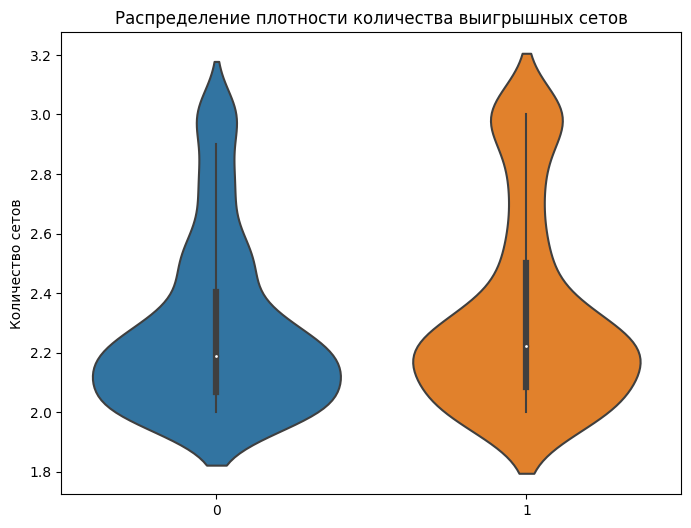

In [20]:
# переименуем для удобства
first_period_sets.name = '1980-2001'
second_period_sets.name = '2002-2022'

plt.figure(figsize=(8, 6))
sns.violinplot(data=[first_period_sets,second_period_sets])
plt.title('Распределение плотности количества выигрышных сетов')
plt.ylabel('Количество сетов')
plt.show()

Гипотеза о том, что число выигрышных сетов уменьшается со временем статистически не верна, т.к. число выигрышных сетов увеличивается (утолщение в районе 3х сетов).

## Задача 3

У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

Используем данные из предыдущей задачи

In [21]:
# оставляем только данные best_of == 5
first_period_data_bof5 = first_period_data.loc[first_period_data['best_of'] == 5]
second_period_data_bof5 = second_period_data.loc[second_period_data['best_of'] == 5]

# Сгруппируем данные по игрокам и вычислим среднее число сетов на победу по периодам
first_period_sets_bof5 = first_period_data_bof5.groupby('winner_id')[
    'total_sets'].mean()
second_period_sets_bof5 = second_period_data_bof5.groupby('winner_id')[
    'total_sets'].mean()

print(first_period_sets_bof5.shape[0])
print(second_period_sets_bof5.shape[0])

251
265


Для проверки данных на нормальность опять используем тест Шапиро-Уитни, он чувствителен и подходит для разных объемов данных

In [22]:
shapiro_test(first_period_sets_bof5, 'первый отрезок')
shapiro_test(second_period_sets_bof5, 'второй отрезок')

Statistic: 0.16811048984527588
P-value: 7.898094233676338e-32
Данные не похожи на нормальное распределение (отвергаем H0)
Statistic: 0.1728515625
P-value: 1.709642804192575e-32
Данные не похожи на нормальное распределение (отвергаем H0)


Т.к. данные распределены не нормально, то используем тест Манна-Уитни

In [23]:
statistic, p_value = mannwhitneyu(
    first_period_sets_bof5, second_period_sets_bof5)

# Вывод результатов
print("Statistic:", statistic)
print("P-value:", p_value)

# Интерпретация результатов
alpha = 0.05
if p_value > alpha:
    print("Нет статистически значимых различий между средними значениями выборок (не отвергаем H0)")
else:
    print("Есть статистически значимые различия между средними значениями выборок (отвергаем H0)")

Statistic: 34061.0
P-value: 0.4415807866856969
Нет статистически значимых различий между средними значениями выборок (не отвергаем H0)


Тест Манна-Уитни говорит об отсутствии статистически значимых различий, для проверки построим Violine plot

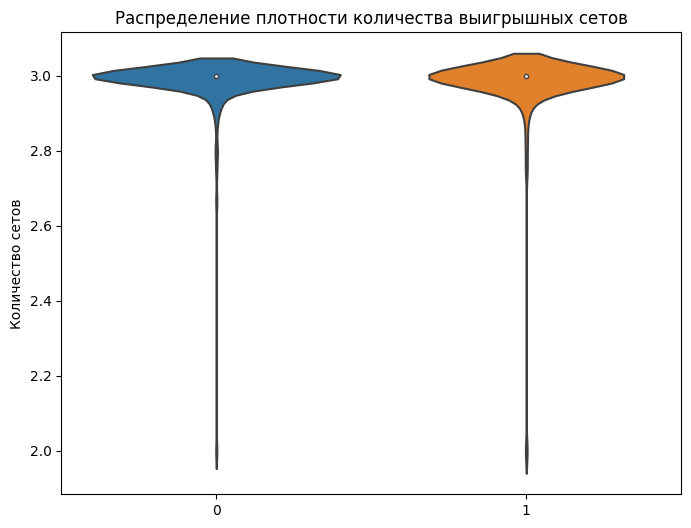

In [24]:
# переименуем для удобства
first_period_sets_bof5.name = '1980-2001'
second_period_sets_bof5.name = '2002-2022'

plt.figure(figsize=(8, 6))
sns.violinplot(data=[first_period_sets_bof5, second_period_sets_bof5])
plt.title('Распределение плотности количества выигрышных сетов')
plt.ylabel('Количество сетов')
plt.show()

Статистически значимая разница между средним количеством сетов, которое сыграл победитель, для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг отсутствует.

## Задача 4

Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис. Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

In [155]:
# Нас интересуют наиболее "производительные" игроки - те, кто за последние 1-0 лет выиграл наибольшее количество матчей 
# берем данные из прошлой задачи
total_frame4 = total_frame1.copy()
# Фильтруем данные - отбираем последние 10 полных лет
recent_data = total_frame4[(total_frame4['year']>= 2013) & (total_frame4['year'] <= 2023)]

# считаем число победных игр за последние 10 лет у каждого игрока
games_played = recent_data.groupby(['winner_id', 'year'])['year'].count().reset_index(name='games_played')

# считаем количество лет сыгранных за последние годы
years_played = games_played.groupby('winner_id').size().reset_index(name='years_played')

# Объединяем полученные данные с исходным DataFrame (2 новых столбца с числом игр за год и количеством лет)
recent_data_with_wins = pd.merge(recent_data, games_played, on=[
                                 'year', 'winner_id'], how='left')
recent_data_with_wins = pd.merge(recent_data_with_wins, years_played, on=[
                                  'winner_id'], how='left')

# оставляем только игроков игравших все 10 лет
recent_data_with_wins_filtered = recent_data_with_wins[recent_data_with_wins['years_played'] == 10]
# оставляем по одной строке на игрока/год (чтобы сосчитать сумму игр)
recent_data_with_wins_unique = recent_data_with_wins.drop_duplicates(subset=[
                                                                     'year', 'winner_id'])

# Суммируем количество игр для каждого игрока (список игрок-количество побед)
players_total_games = recent_data_with_wins_unique.groupby('winner_id')['games_played'].sum().reset_index()
# Выбираем первых трех игроков с наибольшим числом побед
top_3_players = players_total_games.nlargest(3, 'games_played')

print(top_3_players)

# Отбираем строки с игроками из списка selected_players и только игры в которых был брейк-поинт
# w_bpSaved добавлено т.к. есть несколько значений w_bpSaved < 0, исключаем их 
selected_data = recent_data[recent_data['winner_id'].isin(top_3_players['winner_id']) & (recent_data['w_bpFaced'] > 0) & (recent_data['w_bpSaved'] >= 0) ]
selected_data.shape[0]

     winner_id  games_played
179     104925           628
149     104745           491
0       100644           395


1277

В теннисе термины "saved" (спасенные) и "faced" (встреченные) относятся к количеству брейк-поинтов (break points), с которыми столкнулся игрок в течение матча, и сколько из них он смог спасти.

    Faced (встреченные): Это количество раз, когда игрок сталкивался с ситуацией, когда его противнику была предоставлена возможность сделать брейк (то есть выиграть гейм на подаче противника).

    Saved (спасенные): Это количество раз, когда игрок успешно защитил свою игру, не допустив брейка противника при брейк-поинте.

Таким образом bp_Faced - это общее число брейк-поинтов, bp_Saved - число выигранных брейк-поинтов

In [215]:
# Разделение матчей на победные и проигранные
def split_matches(matches_data):
    won_matches = matches_data[matches_data['winner_id'] == player_id]
    lost_matches = matches_data[matches_data['loser_id'] == player_id]
    return won_matches, lost_matches

# 3. Вычисление доли выигранных брейк-поинтов для побед и поражений
def calculate_breakpoint_ratio(matches_data):
    # вычисляем суммы
    total_bpFaced = matches_data['w_bpSaved'].sum()
    total_bpSaved = matches_data['w_bpFaced'].sum()

    # отношение выигранных брейкпоинтов к общему их числу (данные уже очищены от 0 в w_bpFaced)
    return total_bpSaved / total_bpFaced

# список для сохранения данных
players_list = []

# Для каждого из выбранных игроков
for player_id in top_3_players['winner_id']:
    # Получаем данные по всем играм для игрока
    player_data = selected_data[(selected_data['winner_id'] == player_id) | (
        selected_data['loser_id'] == player_id)]
   
    # имя игрока  
    player_name = selected_data[selected_data['winner_id'] == player_id].groupby('winner_id')['winner_name'].first().values[0]

    # добавляем столбец с breakpoint ratio для каждой игры 
    player_data ['bp_ratio'] = player_data ['w_bpSaved'] / player_data ['w_bpFaced']

    # Делим матчи на победные и проигранные
    won_matches, lost_matches = split_matches(player_data)
    
    # Вычисляем долю выигранных брейк-поинтов для игр-побед и игр-поражений
    won_bp_ratio = calculate_breakpoint_ratio(won_matches)
    lost_bp_ratio = calculate_breakpoint_ratio(lost_matches)

    # данные для графиков
    boxplot_data_won = player_data[(player_data['winner_id'] == player_id)][['w_bpFaced', 'w_bpSaved']]
    boxplot_data_lose = player_data[(player_data['loser_id'] == player_id)][['w_bpFaced', 'w_bpSaved']]

    # добавляем данныt по игроку
    players_list.append({'player_id': player_id,'player_name':player_name, 
                         'won_bp_ratio': won_bp_ratio, 'lost_bp_ratio': lost_bp_ratio, 
                         'boxplot_data_won': boxplot_data_won, 'boxplot_data_lose': boxplot_data_lose,
                         'won_matches_ratios': won_matches['bp_ratio'], 'lose_matches_ratios': lost_matches['bp_ratio']
                        })

    print('Player ID: {} {}'.format (player_id, player_name))
    print('   Breakpoint Ratio в победных матчах: {}'.format(won_bp_ratio))
    print('   Breakpoint Ratio в проигранных матчах: {}\n'.format(lost_bp_ratio))

player_results = pd.DataFrame(players_list, columns=[
                              'player_id', 'player_name', 'won_bp_ratio', 'lost_bp_ratio', 'boxplot_data_won', 'boxplot_data_lose', 'won_matches_ratios', 'lose_matches_ratios'])


Player ID: 104925 Novak Djokovic
   Breakpoint Ratio в победных матчах: 1.4632701421800949
   Breakpoint Ratio в проигранных матчах: 1.565217391304348

Player ID: 104745 Rafael Nadal
   Breakpoint Ratio в победных матчах: 1.4429160935350756
   Breakpoint Ratio в проигранных матчах: 1.5909090909090908

Player ID: 100644 Alexander Zverev
   Breakpoint Ratio в победных матчах: 1.4630091438071489
   Breakpoint Ratio в проигранных матчах: 1.4



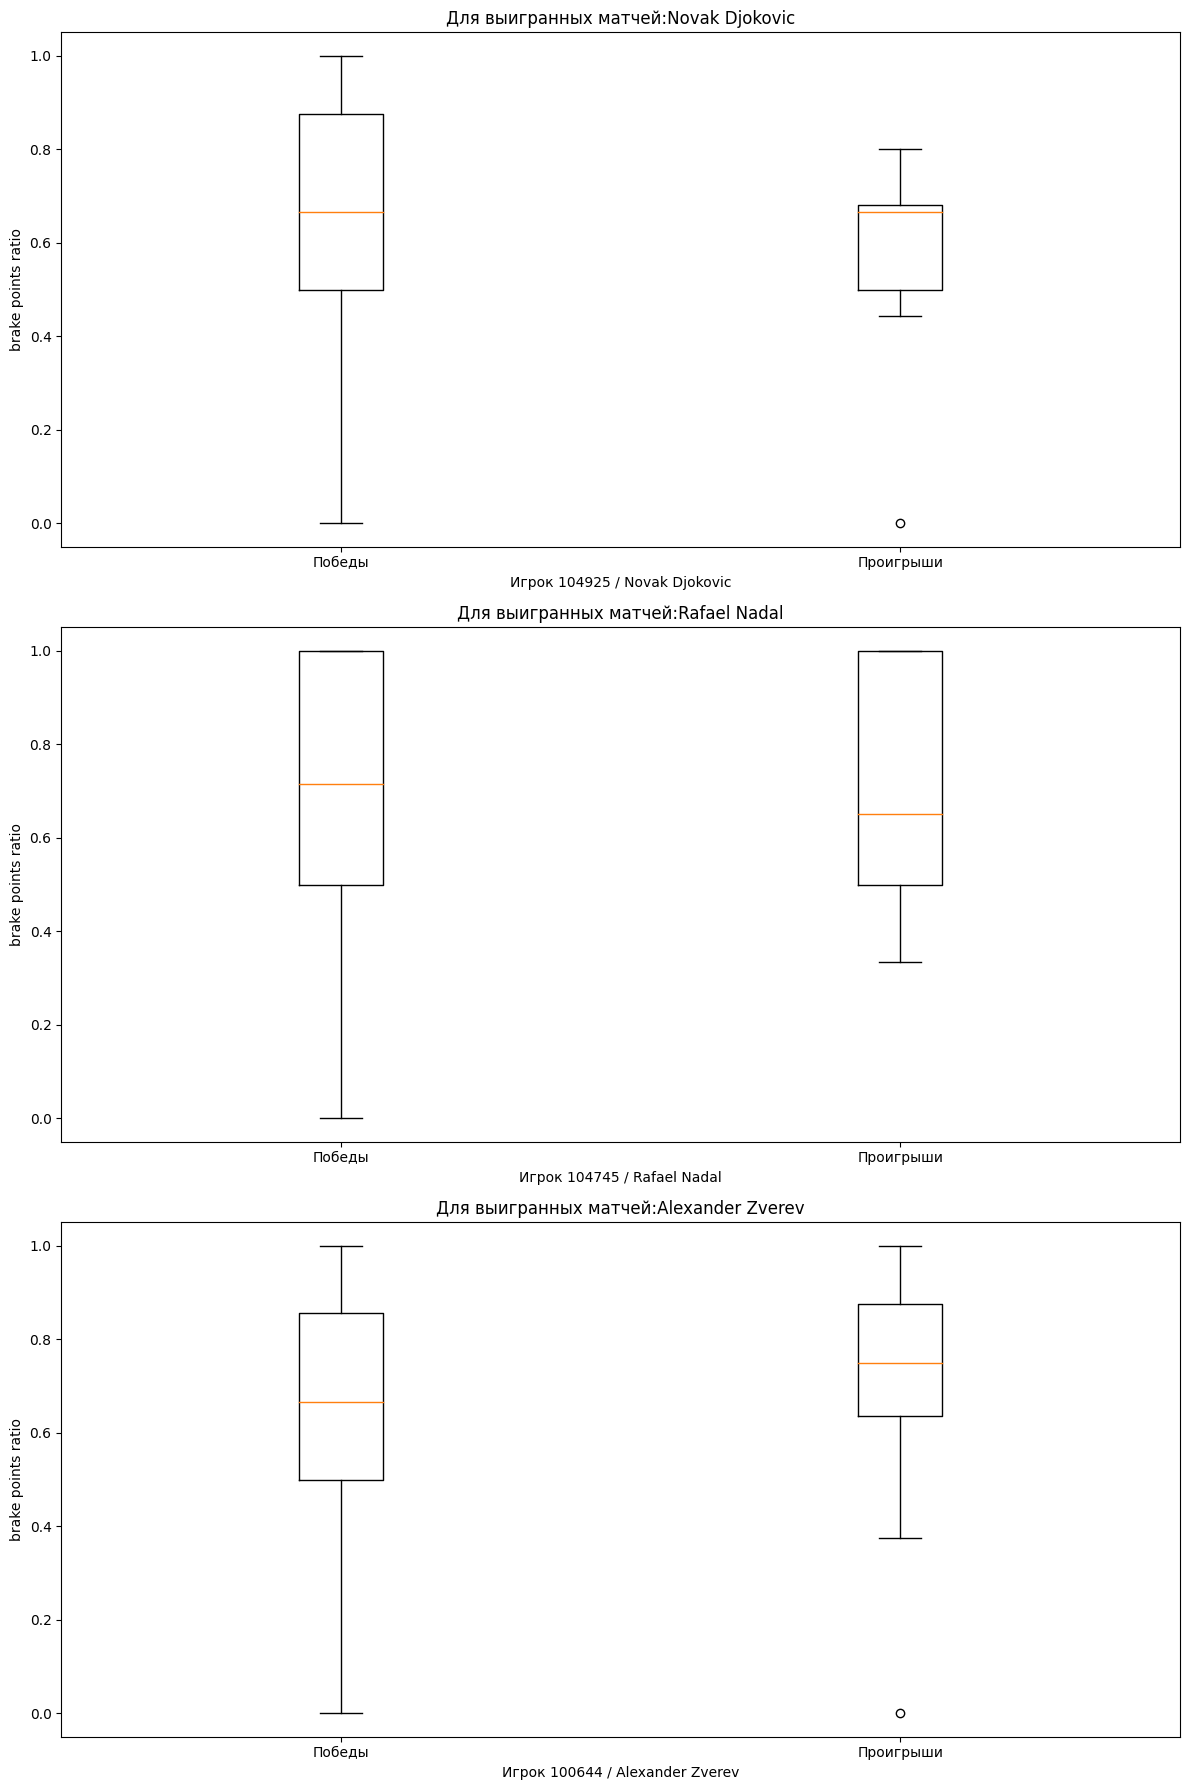

In [216]:
# Создание фигуры и осей для графиков
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Создание подзаголовков для графиков
titles = ['Для выигранных матчей', 'Для проигранных матчей']

# Строим по каждому игроку
for i, player in enumerate(players_list):
    # Вычисление индекса строки и столбца для текущего игрока
    row = i
    
    # Построение boxplot'а для выигранных и проигранных брейк-поинтов
    axes[row].boxplot([player['won_matches_ratios'], player['lose_matches_ratios']], labels=['Победы', 'Проигрыши'])
    axes[row].set_title(titles[0] + ':' + player['player_name'])
    axes[row].set_ylabel('brake points ratio')
    axes[row].set_xlabel('Игрок {} / {}'.format(player['player_id'], player['player_name']))
        
# Отображение графиков
plt.tight_layout()
plt.show()


Мы исследуем количественные данные (break point rate), поэтому можно использовать t-тест для независимых выборок, чтобы сравнить средние значения доли выигранных брейк-поинтов в победных и проигранных матчах для каждого игрока. Если данные не распределены нормально, мы используем непараметрический тест Манна-Уитни.

In [120]:
# Тесты по каждому игроку
for i, player in enumerate(players_list):
        # t-тест для независимых выборок
        t_stat, p_value = ttest_ind(player['won_matches_ratios'], player['lose_matches_ratios'], equal_var=False)
        print ('t-test для {}:\n\t t-stat {}\n\t p-value {}'.format (player['player_name'],t_stat, p_value ))
        # Тест Манна-Уитни
        u_stat, p_value_mw = mannwhitneyu(player['won_matches_ratios'], player['lose_matches_ratios'])
        print ('Манн-Уитни для {}:\n\t u_stat {}\n\t p_value_mw {}'.format (player['player_name'],t_stat, p_value ))


t-test для Novak Djokovic:
	 t-stat 0.9200264936075676
	 p-value 0.375596998773142
Манн-Уитни для Novak Djokovic:
	 u_stat 0.9200264936075676
	 p_value_mw 0.375596998773142
t-test для Rafael Nadal:
	 t-stat -0.26310261022296966
	 p-value 0.7957104436956859
Манн-Уитни для Rafael Nadal:
	 u_stat -0.26310261022296966
	 p_value_mw 0.7957104436956859
t-test для Alexander Zverev:
	 t-stat -0.4098633959386451
	 p-value 0.6885811195372751
Манн-Уитни для Alexander Zverev:
	 u_stat -0.4098633959386451
	 p_value_mw 0.6885811195372751


Для сравнения множественных групп (в данном случае 3х) будем использовать однофакторный ANOVA тест для сравнения средних между группами. Для непараметрического анализа 3х групп можно использовать тест Краскела-Уоллиса.

In [213]:
# Сравнение средних между игроками
# ANOVA тест для сравнения средних между группами выигранных матчей
# Разделение на группы и применение f_oneway

p1,p2,p3 = top_3_players['winner_id'].values[:3]

p1_won = player_results['won_matches_ratios'].where (player_results['player_id'] == p1).dropna().values[0].tolist()
p2_won = player_results['won_matches_ratios'].where (player_results['player_id'] == p2).dropna().values[0].tolist()
p3_won = player_results['won_matches_ratios'].where (player_results['player_id'] == p3).dropna().values[0].tolist()

p1_lose = player_results['won_matches_ratios'].where (player_results['player_id'] == p1).dropna().values[0].tolist()
p2_lose = player_results['won_matches_ratios'].where (player_results['player_id'] == p2).dropna().values[0].tolist()
p3_lose = player_results['won_matches_ratios'].where (player_results['player_id'] == p3).dropna().values[0].tolist()


f_stat, p_value_anova = f_oneway(p1_won, p2_won, p3_won)

print ('ANOVA тест')
print ('Для победных матчей: \n\t f_stat {}\n\t p_value_anova {}'.format(f_stat, p_value_anova))
f_stat, p_value_anova = f_oneway(p1_lose, p2_lose, p3_lose)
print ('Для проигранных матчей: \n\t f_stat {}\n\t p_value_anova {}\n'.format(f_stat, p_value_anova))

# Краскела-Уоллиса тест для сравнения средних между группами выигранных матчей
h_stat, p_value_kruskal = kruskal(p1_won, p2_won, p3_won)
print ('Краскела-Уоллиса тест')
print ('Для победных матчей: \n\t h_stat {}\n\t p_value_kruskal {}'.format(h_stat, p_value_kruskal))
# Краскела-Уоллиса тест для сравнения средних между группами проигранных матчей
h_stat_lost, p_value_kruskal_lost = kruskal(p1_won, p2_won, p3_won)
print ('Для проигранных матчей: \n\t h_stat {}\n\t p_value_kruskal {}'.format(h_stat, p_value_kruskal))



ANOVA тест
Для победных матчей: 
	 f_stat 1.3536921871815983
	 p_value_anova 0.2586561120081326
Для проигранных матчей: 
	 f_stat 1.3536921871815983
	 p_value_anova 0.2586561120081326

Краскела-Уоллиса тест
Для победных матчей: 
	 h_stat 1.748770675752229
	 p_value_kruskal 0.41711832773624913
Для проигранных матчей: 
	 h_stat 1.748770675752229
	 p_value_kruskal 0.41711832773624913
